In [0]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
import re
import numpy as np
import os
import io
import time

In [0]:
#spanish to english dataset
#the input data is in a single file with a tab between input and output 
#and total of 1,18,964 pair sentences are present
path_to_file = "/content/spa.txt"

In [0]:
# Converts the unicode sentence to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [0]:
def preprocess(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿])", r" \1 ", w)#adding a space before the punctuation(\1 is used to tell to use the same symbol that was detected)
  w = re.sub(r'[" "]+', " ", w)#remove more than one space
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)# replacing everything with space except given chars
  w=w.strip()
  w = '<start> ' + w +' <end>'
  return w

In [0]:
en_sentence = u"May I borrow this @#$%^ book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess(en_sentence))
print(preprocess(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
# to create dataset(divide input and output)
def dividedataset(path,maxdata=None):
  alllines=io.open(path,encoding='UTF-8').read().strip().split('\n')#to separate each line by using split at \n
  datapairs=[[preprocess(data) for data in lines.split('\t')]for lines in alllines[:maxdata]]#make a list of tuples of input and target
  return zip(*datapairs)#zip them so that they could be returned separately as a pair(english,spanish)

In [0]:
en, sp = dividedataset(path_to_file, None)
en,sp=shuffle(en,sp)
print(len(en))
print(len(sp))
print(en[-1])
print(sp[-1])

118964
118964
<start> are you getting along with your neighbors ? <end>
<start> ¿ te llevas bien con tus vecinos ? <end>


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(text):
  tokenizer=tf.keras.preprocessing.text.Tokenizer(filters='')
  tokenizer.fit_on_texts(text)
  encodedtext=tokenizer.texts_to_sequences(text)
  encodedtext=tf.keras.preprocessing.sequence.pad_sequences(encodedtext,padding='post')#zero pad to max length
  return encodedtext,tokenizer
print(tokenize(["May I borrow this book"])[0])

[[1 2 3 4 5]]


In [0]:
def makedataset(path,maxdata=None):
   target,inp=dividedataset(path,maxdata)
   inputdata,inputdict=tokenize(inp)#inp is spanish,target is english
   targetdata,targetdict=tokenize(target)#
   return inputdata,inputdict,targetdata,targetdict# returning the tokenizer cause it is a dictionary of word to index

In [0]:
inputdata,inputdict,targetdata,targetdict=makedataset(path_to_file,67000)
print(inputdata.shape,targetdata.shape)#(67,000 sentence pairs)

(67000, 20) (67000, 14)


In [0]:
print(inputdata[0])#spanish
print(targetdata[0])#english
input_length=inputdata.shape[1]
target_length=targetdata.shape[1]

[  1 218   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[ 1 44  3  2  0  0  0  0  0  0  0  0  0  0]


In [0]:
# Creating training and validation sets using an 80-20 split
input_train, input_test, target_train, target_test = train_test_split(inputdata, targetdata, test_size=0.2)

In [0]:
totalsize = len(input_train)
BATCH_SIZE = 64
steps_per_epoch = totalsize//BATCH_SIZE
embedding_dim = 300
gruunits = 1024
vocab_size_input = len(inputdict.word_index)+1
vocab_size_target = len(targetdict.word_index)+1
batchdataset = tf.data.Dataset.from_tensor_slices((input_train, target_train)).shuffle(totalsize)#gives batches of dataset 
batchdataset = batchdataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
example_input_batch, example_target_batch = next(iter(batchdataset))
print("input_batch shape ",example_input_batch.shape)
print("target_batch shape ",example_target_batch.shape)

input_batch shape  (64, 20)
target_batch shape  (64, 14)


In [0]:
class encoder_model(tf.keras.Model):#using the keras model class
  def __init__(self,vocabsize,embedsize,rnnunits,batch):
    super(encoder_model,self).__init__()
    self.units=rnnunits
    self.batchsize=batch
    self.embedlayer=tf.keras.layers.Embedding(vocabsize,embedsize)
    self.gru=tf.keras.layers.GRU(rnnunits,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
  
  def call(self,input,hidden):
    out=self.embedlayer(input)
    output,finalstate=self.gru(out)#the last time step output and the final hidden are same
    return output,finalstate
  
  def initalise(self):#this method is required because while evaluating tests the initial hidden to encoder wont be of size batchsize and so the hidden state need to be given as parameter for encoder()
    return tf.zeros((self.batchsize,self.units))

In [0]:
encoder=encoder_model(vocab_size_input,embedding_dim,gruunits,BATCH_SIZE)
hidden=encoder.initalise()
output,hiddenstate=encoder(example_input_batch,hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(hiddenstate.shape))

Encoder output shape: (batch size, sequence length, units) (64, 20, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class Attention(tf.keras.layers.Layer):
  def __init__(self,FCunits):
    super(Attention,self).__init__()
    self.units=FCunits
    self.w1=tf.keras.layers.Dense(FCunits)#for encoderoutput
    self.w2=tf.keras.layers.Dense(FCunits)#for previous hiddenstate
    self.v=tf.keras.layers.Dense(1)

  def call(self,hiddenstate,encoderoutput):
    hiddenstate=tf.expand_dims(hiddenstate,1)#to make it equal dim as encoderoutput so that they can be added
    alignment=self.v(tf.nn.tanh(self.w1(encoderoutput)+self.w2(hiddenstate)))
    attention=tf.nn.softmax(alignment,axis=1)#apply softmax
    context=attention*encoderoutput
    context=tf.reduce_sum(context,axis=1)#adding all the words i.e.all timesteps
    return context, attention#To plot the attention weights

In [0]:
attention=Attention(20)
context,weights=attention(hiddenstate,output)
print ('context vector output shape: (batch size, units) {}'.format(context.shape))

context vector output shape: (batch size, units) (64, 1024)


In [0]:
class decoder_model(tf.keras.Model):
  def __init__(self,rnnunits,vocabsize,embedsize):
    super(decoder_model,self).__init__()
    self.units=rnnunits
    self.embedlayer=tf.keras.layers.Embedding(vocabsize,embedsize)
    self.gru=tf.keras.layers.GRU(rnnunits,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
    self.fclayer=tf.keras.layers.Dense(vocabsize)
    self.attention=Attention(rnnunits)

  def call(self,encoderoutput,hiddenstate,inputword):
      context,attention_weights=self.attention(hiddenstate,encoderoutput)
      output=self.embedlayer(inputword)
      context=tf.expand_dims(context,1)#to match it to dimensions of output(batchsize,1,embedsize)
      gruinput=tf.concat([context,output],-1)
      output,finalhidden=self.gru(gruinput)
      output=tf.reshape(output, (-1, output.shape[2]))#make (batchsize,1,units) to (batchsize,units)
      output=self.fclayer(output)#fc layer to produce onehot of the output
      return output,finalhidden,attention_weights

In [0]:
decoder=decoder_model(gruunits,vocab_size_target,embedding_dim)
decoderoutput,hid,w=decoder(output,hiddenstate,tf.random.uniform((BATCH_SIZE, 1)))
print ('Decoder output shape: (batch_size, vocab size) {}'.format(decoderoutput.shape))
print ('Decoder hidden shape: (batch_size, units) {}'.format(hid.shape))

Decoder output shape: (batch_size, vocab size) (64, 8248)
Decoder hidden shape: (batch_size, units) (64, 1024)


In [0]:
optimizer = tf.keras.optimizers.Adam()
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def findloss(actual,pred):
  mask = tf.math.logical_not(tf.math.equal(actual, 0))#to check if any index of the sentence is mistakenly encoded to 0(if yes then loss corresponding that is made 0)
  losss = crossentropy(actual, pred)
  mask = tf.cast(mask, dtype=losss.dtype)
  losss *= mask
  return tf.reduce_mean(losss)# mean of the array

In [0]:
@tf.function
def trainbatch(inputs,target,encoderhidden):
  loss=0
  with tf.GradientTape() as tape:
    encoderoutput,encoderhidden=encoder(inputs,encoderhidden)
    decoderhidden=encoderhidden#for first time step
    decoderinput=tf.expand_dims([targetdict.word_index['<start>']] * BATCH_SIZE, 1)#a input of (64,1) and each input is index of <start>
    for time in range(1,target.shape[1]):#the total timesteps
       decoderoutput,decoderhidden,_=decoder(encoderoutput,decoderhidden,decoderinput)
       loss+=findloss(target[:,time],decoderoutput)#target[:,time] is the first word of all batches
       decoderinput=tf.expand_dims(target[:,time],1)#teacherforcing
    batchloss=loss/int(target.shape[1])
  weights=encoder.trainable_variables+decoder.trainable_variables
  gradients = tape.gradient(loss, weights)
  optimizer.apply_gradients(zip(gradients, weights))
  return batchloss

In [0]:
testdataset = tf.data.Dataset.from_tensor_slices((input_test, target_test)).shuffle(input_test.shape[0])#gives batches of dataset 
testdataset = testdataset.batch(BATCH_SIZE, drop_remainder=True)
steps=input_test.shape[0]//BATCH_SIZE

In [0]:
def validationloss(input_test,target_test):
  totalloss=0
  for (batch,(inputs,target)) in enumerate(testdataset.take(steps)):
     encoderhidden=tf.zeros((BATCH_SIZE,gruunits))
     encoderoutput,encoderhidden=encoder(inputs,encoderhidden)
     decoderhidden=encoderhidden
     decoderinput=tf.expand_dims([targetdict.word_index['<start>']]*BATCH_SIZE,1)
     loss=0
     for time in range(1,target_test.shape[1]):
      decoderoutput,decoderhidden,_=decoder(encoderoutput,decoderhidden,decoderinput)
      loss+=findloss(target[:,time],decoderoutput)
      decoderinput=tf.argmax(decoderoutput,axis=1)
      decoderinput=tf.reshape(decoderinput,(decoderinput.shape[0],1))
     batchloss=loss/int(target_test.shape[1])
     totalloss+=batchloss
  return totalloss/steps

In [0]:
def train(epochs):
 Train_loss=[]
 for epoch in range(epochs):
   start = time.time()
   netloss=0
   count=0
   encoderhidden=encoder.initalise()
   progbar = tf.keras.utils.Progbar(steps_per_epoch)
   for (batch,(inputs,targets)) in enumerate(batchdataset.take(steps_per_epoch)):
     batchloss=trainbatch(inputs,targets,encoderhidden)
     netloss+=batchloss
     if batch % 100 == 0:
      print('\nEpoch {} Batch {} Loss {:.4f}'.format(epoch + 1,batch,batchloss.numpy()))
     count+=1
     progbar.update(count)   
   print('Epoch {} Loss {:.4f}'.format(epoch + 1,netloss / steps_per_epoch))
   Train_loss.append((netloss / steps_per_epoch))
   l=validationloss(input_test,target_test)
   print("The validation/test loss after epoch {} is {:.4f}".format(epoch+1,l))
   print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
 return Train_loss  

In [0]:
EPOCHS=20
Train_loss=train(EPOCHS)


Epoch 1 Batch 0 Loss 4.3480
100/837 [==>...........................] - ETA: 3:34
Epoch 1 Batch 100 Loss 2.2263
200/837 [======>.......................] - ETA: 2:20
Epoch 1 Batch 200 Loss 1.9925
300/837 [=========>....................] - ETA: 1:45
Epoch 1 Batch 300 Loss 1.8019
400/837 [=============>................] - ETA: 1:20
Epoch 1 Batch 400 Loss 1.6228
500/837 [================>.............] - ETA: 59s
Epoch 1 Batch 500 Loss 1.6081
600/837 [====================>.........] - ETA: 40s
Epoch 1 Batch 600 Loss 1.4327
700/837 [========================>.....] - ETA: 23s
Epoch 1 Batch 700 Loss 1.5059
800/837 [===========================>..] - ETA: 6s
Epoch 1 Batch 800 Loss 1.3407
837/837 [==============================] - 138s 165ms/step
Epoch 1 Loss 1.7546
The validation/test loss after epoch 1 is 2.5931
Time taken for 1 epoch 159.72612071037292 sec


Epoch 2 Batch 0 Loss 1.1213
100/837 [==>...........................] - ETA: 1:49
Epoch 2 Batch 100 Loss 1.1519
200/837 [======>.........

In [0]:
def plot(trainloss,EPOCHS):
  epochs_range=range(EPOCHS)
  plt.figure(figsize=(10, 10))
  plt.plot(epochs_range, trainloss, label='Training Loss')
  plt.title('Training Loss')


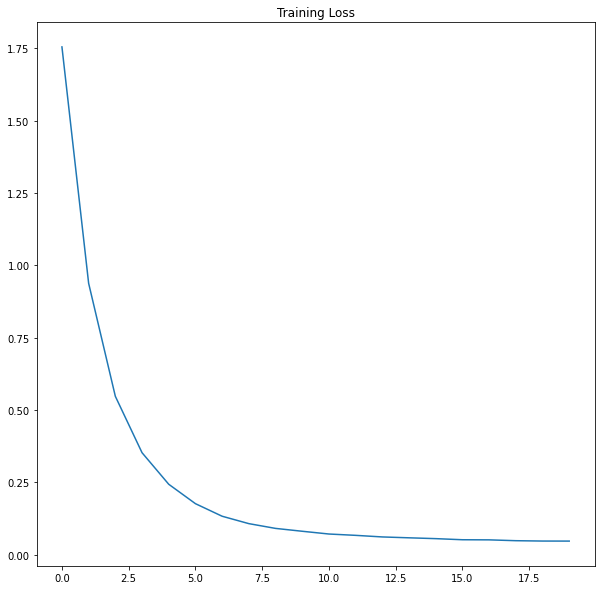

In [0]:
plot(Train_loss,EPOCHS)

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((target_length, input_length))
  w=preprocess(sentence)
  encoded=[inputdict.word_index[i] for i in w.split(' ')]
  encoded=tf.keras.preprocessing.sequence.pad_sequences([encoded],maxlen=example_input_batch.shape[1],padding='post')
  encoded=tf.convert_to_tensor(encoded)
  translated=''
  initialhidden=tf.zeros((1,gruunits))
  encoderoutput,encoderhidden=encoder(encoded,initialhidden)
  decoderhidden=encoderhidden
  decoderinput=tf.expand_dims([targetdict.word_index['<start>']],0)
  for time in range(example_target_batch.shape[1]):
     decoderoutput,decoderhidden,attention_weights=decoder(encoderoutput,decoderhidden,decoderinput)
     attention_weights = tf.reshape(attention_weights, (-1, ))#to plot the attention
     attention_plot[time] = attention_weights.numpy()
     predictedid=tf.argmax(decoderoutput[0]).numpy()
     translated+=targetdict.index_word[predictedid]+' '
     if (targetdict.index_word[predictedid]=='<end>'):
       return translated,attention_plot
     decoderinput=tf.expand_dims([predictedid],0)
  
  return translated,attention_plot

In [0]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  cax=ax.matshow(attention, cmap='viridis')
  fig.colorbar(cax)
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()


In [0]:
def translate(sentence):
  result,attention_plot= evaluate(sentence)
  sen=preprocess(sentence)
  print('Input: %s' % (sen))
  print('Predicted translation: {}'.format(result))
  attention_plot = attention_plot[:len(result.split(' ')), :len(sen.split(' '))]
  plot_attention(attention_plot, sen.split(' '), result.split(' '))

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


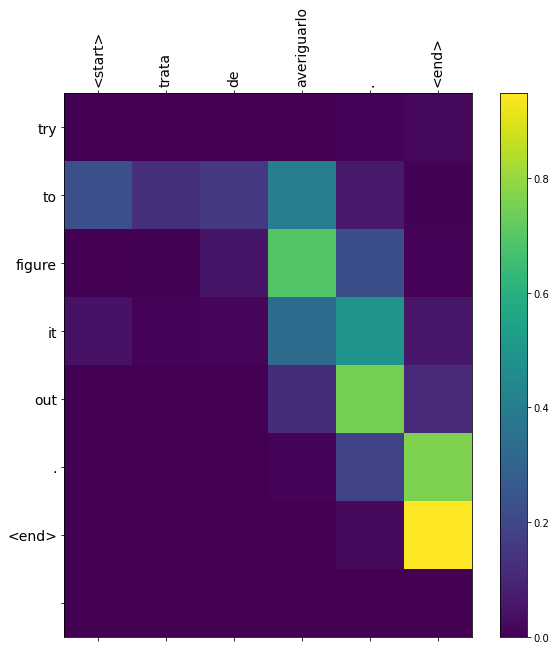

The ground truth is - try to find out


In [0]:
translate(u'trata de averiguarlo.')
print("The ground truth is - try to find out")

Input: <start> soy el presidente de este pais <end>
Predicted translation: i m the president of this country . <end> 


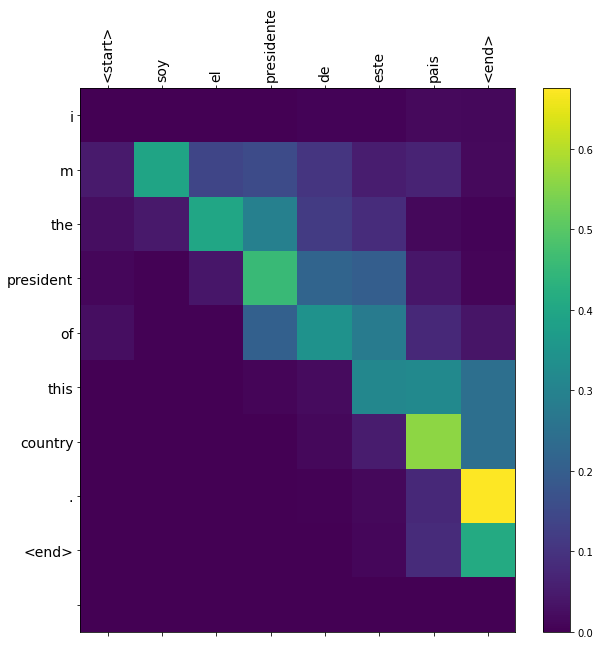

The ground truth is - I am the president of this country


In [0]:

translate(u'Soy el presidente de este pais')
print("The ground truth is - I am the president of this country")

Input: <start> te quiere mucho <end>
Predicted translation: he loves you very much . <end> 


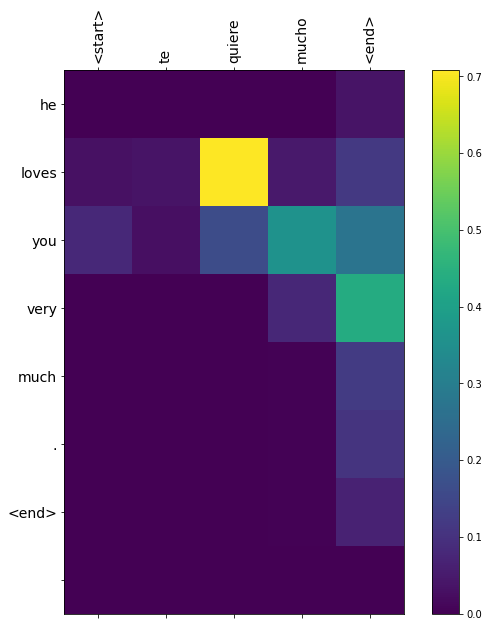

In [0]:
translate(u'Te quiere mucho')
print("The ground truth is - He loves you very much")

Input: <start> no sabia que eras de boston . <end>
Predicted translation: i didn t know you were in boston . <end> 


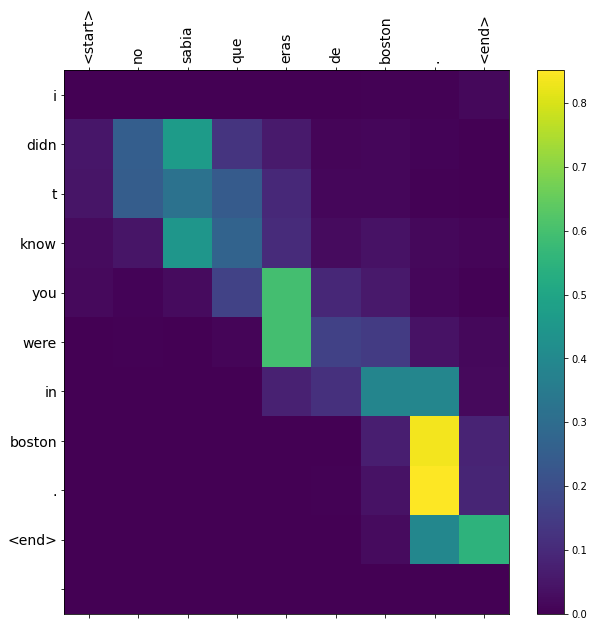

The ground truth is- I didnt know you were from boston


In [0]:
translate(u'No sabía que eras de Boston.')
print("The ground truth is- I didnt know you were from boston")

Input: <start> estoy cansada , pero no puedo quedarme dormida . <end>
Predicted translation: i m tired , i can t sleep in . <end> 


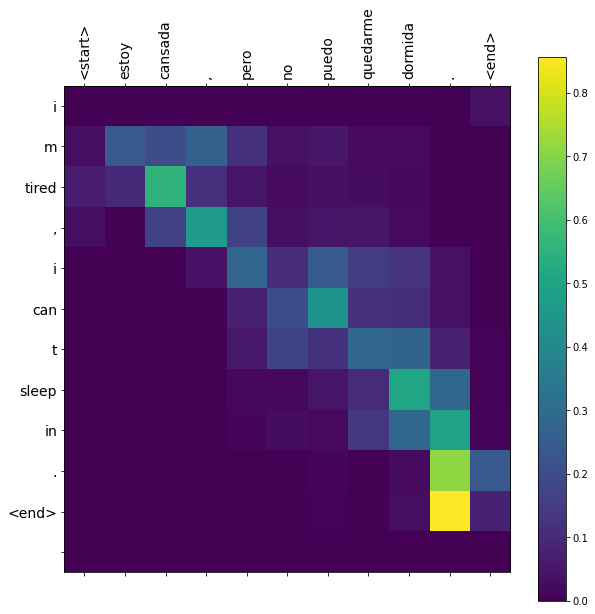

The ground truth is -I am tired, but I cannot fall asleep


In [0]:
translate(u'Estoy cansada, pero no puedo quedarme dormida.')
print("The ground truth is -I am tired, but I cannot fall asleep")

Input: <start> no recuerdo haberte invitado . <end>
Predicted translation: i don t remember inviting you . <end> 


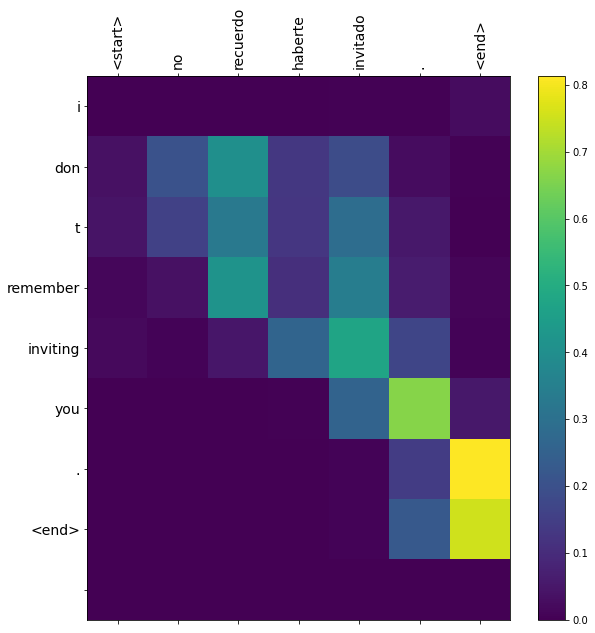

In [0]:
translate(u'No recuerdo haberte invitado.')
print("The ground truth is -I don't remember inviting you.")

Input: <start> apenas puedo entender lo que el dice . <end>
Predicted translation: i can hardly understand what he says . <end> 


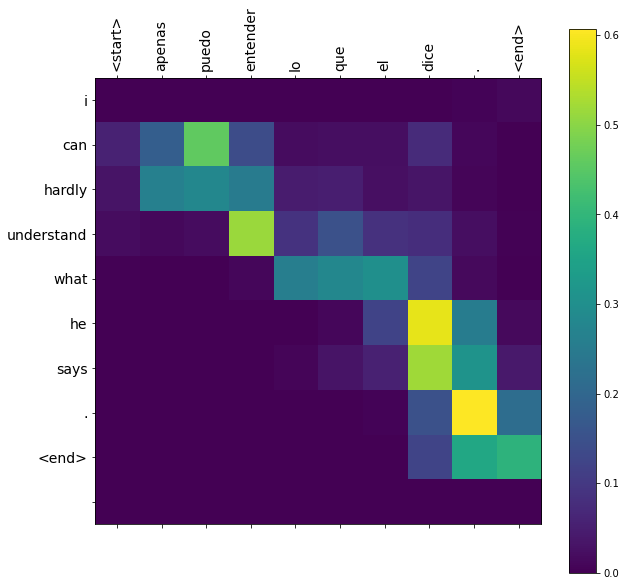

The ground truth is- I can hardly make out what he says


In [0]:
translate(u'Apenas puedo entender lo que él dice.')
print("The ground truth is- I can hardly make out what he says")

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


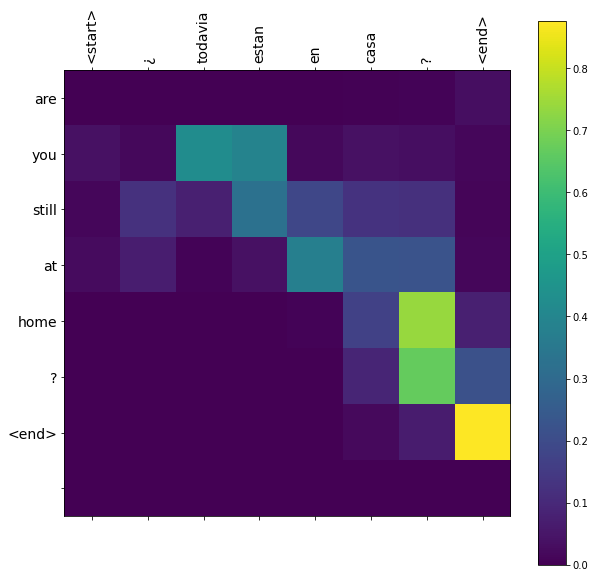

The ground truth is -Are they still home


In [0]:
translate(u'¿todavia estan en casa?')
print("The ground truth is -Are they still home")

Input: <start> quiero decirte que eres muy hermosa <end>
Predicted translation: i want to tell you are very beautiful . <end> 


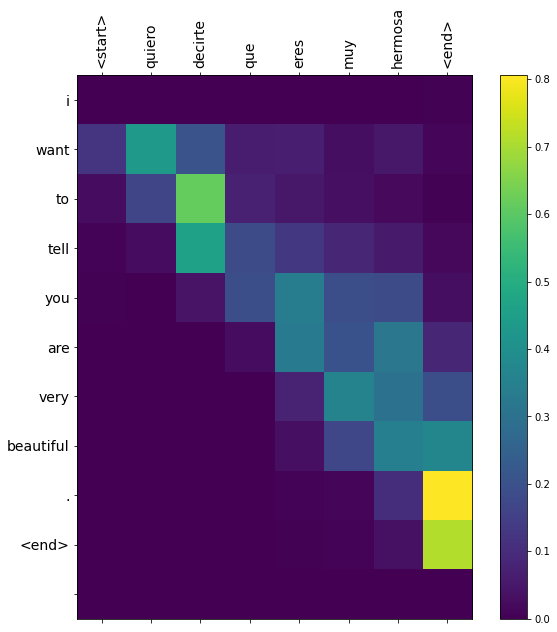

The ground truth is - I want to tell you that you are very beautiful


In [0]:
translate(u'Quiero decirte que eres muy hermosa')
print("The ground truth is - I want to tell you that you are very beautiful")

Input: <start> el ingles es dificil de aprender . <end>
Predicted translation: english is hard to learn . <end> 


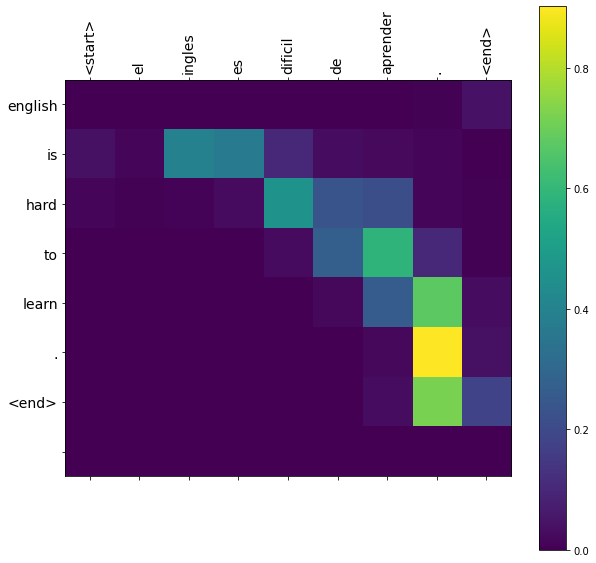

The ground truth is -English is difficult to learn.


In [0]:
translate(u'El inglés es difícil de aprender.')
print("The ground truth is -English is difficult to learn.")

Input: <start> su esposa es una mujer talentosa . <end>
Predicted translation: her wife is a famous woman . <end> 


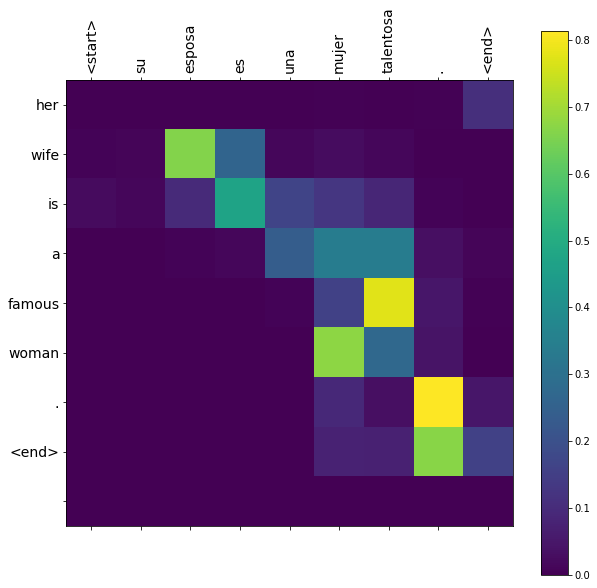

The ground truth is -His wife is a talented woman


In [0]:
translate(u'Su esposa es una mujer talentosa.')
print("The ground truth is -His wife is a talented woman")

Input: <start> ¿ has terminado de leer el libro ? <end>
Predicted translation: have you finished the book ? <end> 


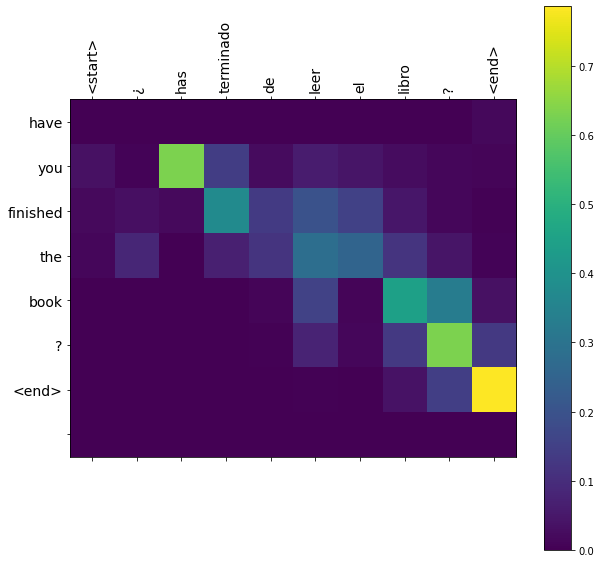

The ground truth is - Have you finished reading the book ?


In [0]:
translate(u'¿Has terminado de leer el libro?')
print('The ground truth is - Have you finished reading the book ?')

Input: <start> el me trata como si fuera un extrano . <end>
Predicted translation: he treats me how i m an outsider . <end> 


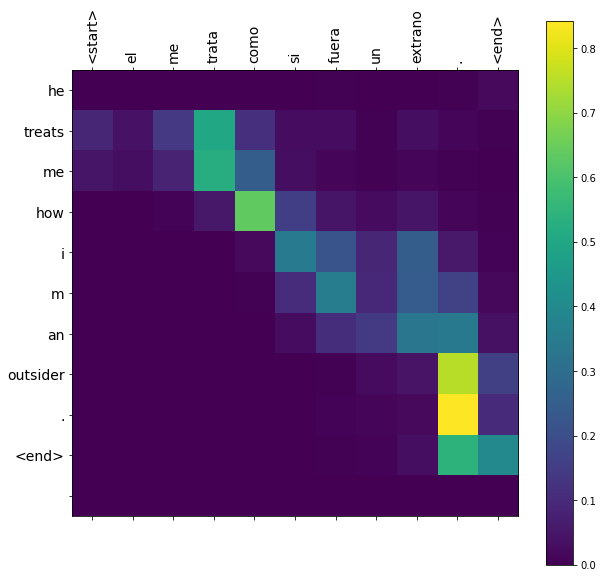

The ground truth is - He treats me like I am a stranger


In [0]:
translate(u'Él me trata como si fuera un extraño. ')
print("The ground truth is - He treats me like I am a stranger")